In [6]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 常用的图像增广方法

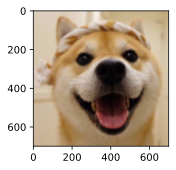

In [7]:
d2l.set_figsize()
img = Image.open('img/tx.png')
d2l.plt.imshow(img)

定义绘图函数

In [8]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes  # 这里返回所有图像的索引没有用

In [9]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

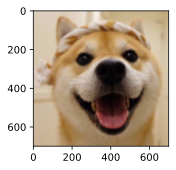

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('img/tx.png')
plt.imshow(img)

# 翻转和裁剪

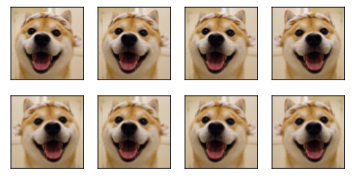

In [11]:
# 以给定的概率水平翻转给定的图像。
apply(img, torchvision.transforms.RandomHorizontalFlip())

我们每次随机裁剪出一块面积为原面积10%∼100%的区域，且该区域的宽和高之比随机取自0.5∼2

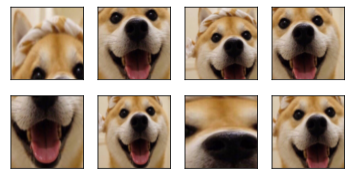

In [12]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

# 变化颜色

在下面的例子里，我们将图像的亮度随机变化为原图亮度的50%（1−0.5）∼150%（1+0.5）。

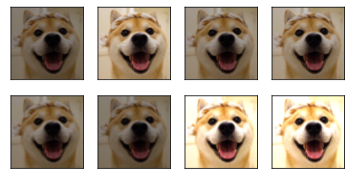

In [13]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

我们也可以随机变化图像的色调。

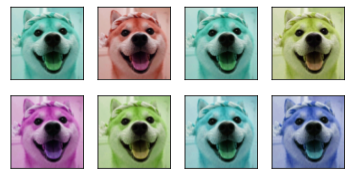

In [14]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

我们也可以同时设置如何随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。

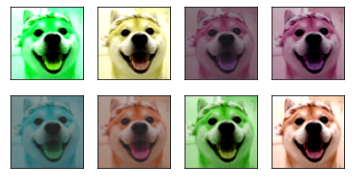

In [15]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

# 叠加多个图像增广的方法

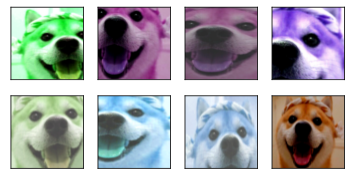

In [16]:
augs = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)


# 使用图像增广训练模型

In [17]:
all_images = torchvision.datasets.CIFAR10(train=True, root="~/Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)

Files already downloaded and verified


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

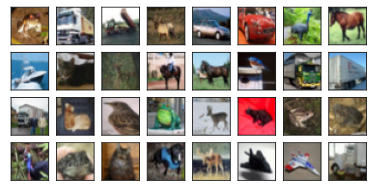

In [18]:
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

在这里我们只使用最简单的随机左右翻转。此外，我们使用ToTensor将小批量图像转成PyTorch需要的格式，即形状为(批量大小, 通道数, 高, 宽)、值域在0到1之间且类型为32位浮点数。

In [19]:
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。有关DataLoader的详细介绍，可参考更早的3.5节图像分类数据集(Fashion-MNIST)。

In [20]:
num_workers = 0 
def load_cifar10(is_train, augs, batch_size, root="~/Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

使用图像增广训练图片

我们先定义train函数使用GPU训练并评价模型。

In [21]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [22]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)


模型太大，训练不了